# Market Shock Recovery Patterns: Statistical Analysis of S&P 500 Stock Reactions

----

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import yfinance as yf
import pandas as pd
import plotly.express as px
from IPython.display import display, HTML

#### Table of Contents 

1. [Introduction](#1ntroduction)
2. [Theoretical Framework & Methodology](#2-theoretical-framework--methodology)
3. [Data Collection & Preparation](#3-data-collection--preparation)
4. [Identifying Crashes](#4-identifying-crashes)



## 1. Introduction

This project aims to analyze and understand potential abnormal reactions of the S&P 500 to stock market shocks from 2015 to 2025. Specifically, it tests whether large market crashes are followed by **statistically significant** positive returns consistent with return reversals or investor overreaction (De Bondt and Thaler, 1995). For the investor, this translates to whether they can profit by buying stocks right after a their values crash. 

The COVID-19 crash of March 2020 caused a 34% fall on the S&P 500 in just 23 days, yet stocks recovered most losses within weeks. By the end of 2020, the market was significantly higher than its initial value before the pandemic. More recently, Trump's *Liberation Day* led to losses amounting to over 10% of the S&P 500 companies, followed by a full recovery a month later. 

Understanding post-shock returns is crucial for many reasons:
- Investors deciding whether to buy during market panic
- Risk managers assessing portfolio behavior during stress periods
- Academics testing market efficiency (EMH)



## 2. Theoretical Framework & Methodology

### Market Crash

A market crash is an unusually large single-day S&P 500 decline. It is calculated based on the close-to-close return from day $t-1$ to day $t$. Similarly for individual stocks, a large negative shock is a sudden drop in price. Although such declines are often characterized by fixed thresholds, like losses of 3-5% or more, these absolute values may not show the same relevance across firms. Since companies have different characteristics, like volatility, the use of a relative measure is better suited to our objective.


To illustrate the flaw in using absolute thresholds, let's briefly look at market shocks for two companies: Apple and Tesla.

In [170]:
apple = yf.download("AAPL", start="2015-01-01", end="2025-12-31")
tesla = yf.download("TSLA", start="2015-01-01", end="2025-12-31")
threshold = -0.05

apple["Daily Return"] = apple["Close"].pct_change()
tesla["Daily Return"] = tesla["Close"].pct_change()

apple_crash_days = apple[apple["Daily Return"] <= threshold]
tesla_crash_days = tesla[tesla["Daily Return"] <= threshold]

print(f"Number of \"crash\" days for Apple: {len(apple_crash_days)}")
print(f"Number of \"crash\" days for Tesla: {len(tesla_crash_days)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Number of "crash" days for Apple: 24
Number of "crash" days for Tesla: 161


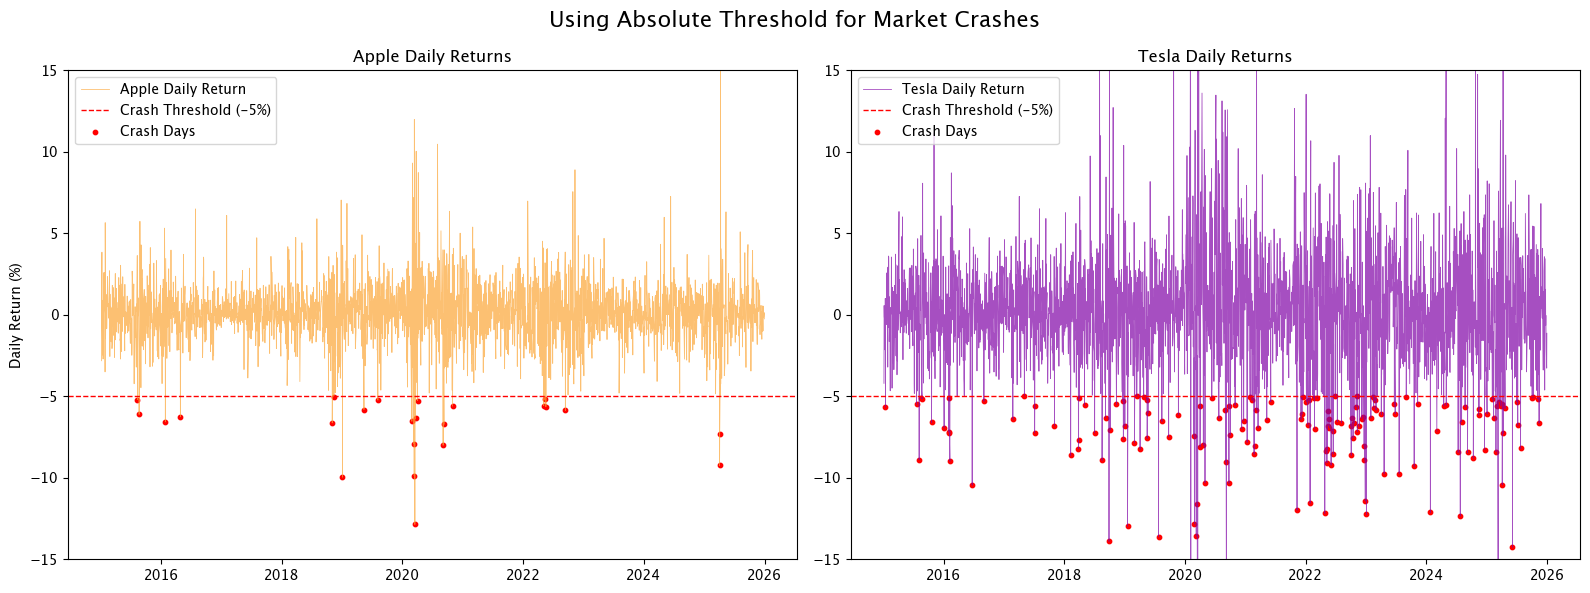

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

y_min = -15
y_max = 15

# Apple
ax1.plot(apple.index, apple["Daily Return"]*100, label="Apple Daily Return", linewidth=0.6, color=cm.plasma(0.8), alpha=0.7)
ax1.axhline(y=-5, color="red", linestyle="--", linewidth=1, label="Crash Threshold (-5%)")
ax1.scatter(apple_crash_days.index, apple_crash_days["Daily Return"]*100, color="red", s=10,label="Crash Days")
ax1.set_title("Apple Daily Returns")
ax1.set_ylabel("Daily Return (%)")
ax1.set_ylim(y_min, y_max)
ax1.legend()

# Tesla
ax2.plot(tesla.index, tesla["Daily Return"]*100, label="Tesla Daily Return", linewidth=0.6, color=cm.plasma(0.26), alpha=0.7)
ax2.axhline(y=-5, color="red", linestyle="--", linewidth=1, label="Crash Threshold (-5%)")
ax2.scatter(tesla_crash_days.index, tesla_crash_days["Daily Return"]*100, color="red", s=10, label="Crash Days")                
ax2.set_title("Tesla Daily Returns")
ax2.set_ylim(y_min, y_max) 
ax2.legend(loc="upper left")


plt.suptitle("Using Absolute Threshold for Market Crashes", fontsize=16)
plt.tight_layout()
plt.show()

Using the same 5% threshold yields vastly different results for both companies. Under this definition, Apple would experience roughly 7 times less "crashes" than Tesla. But since Tesla's volatility is significantly higher, such comparison is generally misleading. The same percentage decline may represent a routine fluctuation for a high-volatility stock but an extreme event for a more stable firm.

Instead, we may adopt a more comprehensive measure by defining a crash as a day on which the return decreases below the **mean daily return minus two standard deviations**. By noting $r_t$ the daily return, $\mu$ the mean daily return from 2015 to 2025 and $\sigma$ the corresponding standard deviation, we may formalize a market crash or shock as a day when: 

$$r_t< \mu - 2\sigma$$

Under the assumption that returns are *approximately* normally distributed, about 95% of observations lie within two standard deviations of the mean. Consequently, a return below $\mu - 2\sigma$ corresponds to roughly the lowest 2.5% of outcomes, which translates to statistically rare negative movements. 

### Abnormal Returns & CPAM

To determine if a stock's recovery is *exceptional*, we first need to determine what "normal" recovery looks like. We use the concept of **abnormal returns**:

$$\text{Abnormal Return} = \text{Actual Return} - \text{Expected Return}$$

**Expected return** is the predicted return of the stock, based on:
1. The stock's historical sensitivity to market movements $\beta$
2. The overall performance of the market on that day

If a stock rebounds more than expected (positive abnormal return), it outperformed its historical pattern. Conversely, if it rebounds less (negative abnormal return), it underperformed.




## 3. Data Collection & Preparation 

In [109]:
# Config
start_date = "2015-01-01"
end_date = "2025-12-31"

df = pd.read_csv("dataset/constituents.csv")
df.columns

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='str')

### S&P 500 Companies by Sector

GICS Sector
Energy                     4.37%
Communication Services     4.77%
Materials                  5.17%
Utilities                  6.16%
Real Estate                6.16%
Consumer Staples           7.55%
Consumer Discretionary    10.14%
Health Care               11.93%
Information Technology    13.52%
Financials                14.71%
Industrials               15.51%
Name: count, dtype: str


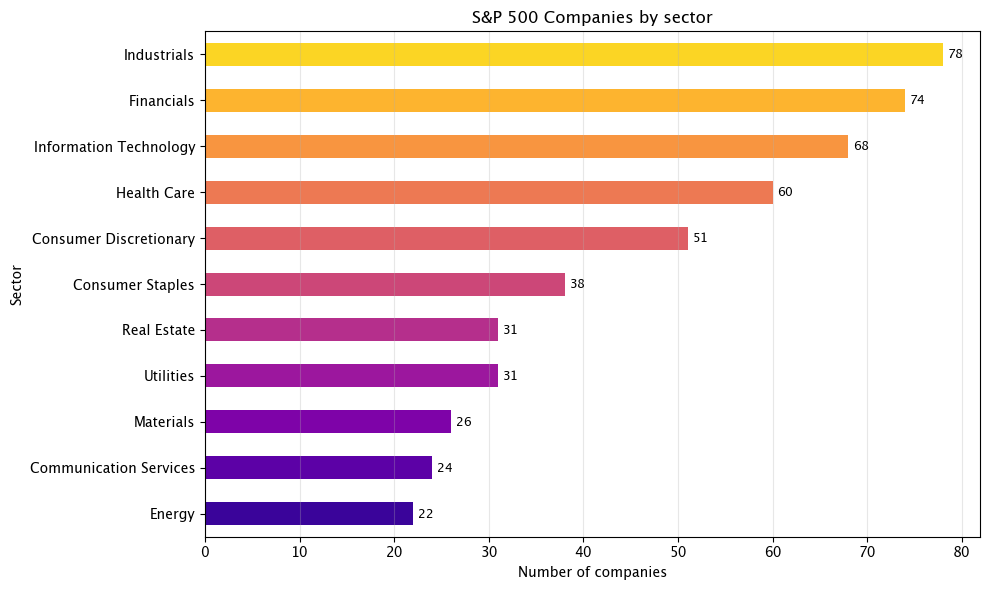

In [218]:
sector_counts = df["GICS Sector"].value_counts().sort_values(ascending=True)
sector_proportion = sector_counts / sector_counts.sum()

print((sector_proportion*100).round(2).astype(str) + "%")

ax3 = sector_counts.plot(kind="barh", figsize=(10,6), color=sns.color_palette("plasma", len(sector_counts)), title="S&P 500 Companies by sector")
ax3.grid(axis="x", alpha=0.3)

ax3.set_xlabel("Number of companies")
ax3.set_ylabel("Sector")

for index, value in enumerate(sector_counts):
    ax3.text(value + 0.5, index, str(value), va="center", fontsize=9)

plt.tight_layout()
plt.show()

### Stratified Sampling

We sample 50 companies (or 10%) of the S&P 500 with a representative proportion in each sector. Below is the number of companies required per sector.

In [174]:
sample_size = 50
samples_per_sector = (df["GICS Sector"].value_counts(normalize=True) * sample_size).round().astype(int)
print(samples_per_sector)

GICS Sector
Industrials               8
Financials                7
Information Technology    7
Health Care               6
Consumer Discretionary    5
Consumer Staples          4
Utilities                 3
Real Estate               3
Materials                 3
Communication Services    2
Energy                    2
Name: proportion, dtype: int64


In [ ]:
final_sample = pd.DataFrame()

df_remaining = df[["Symbol", "GICS Sector"]].copy() # in order to avoid duplicate
samples_per_sector = (df["GICS Sector"].value_counts(normalize=True) * sample_size).round().astype(int)

randomstate = 666

# Looping through each sector and sampling the required number for each

for sector in set(df["GICS Sector"]):
    required_number = samples_per_sector.get(sector, 0)

    sampled_rows = df[df["GICS Sector"] == sector].sample(n=required_number, random_state=randomstate)

    final_sample = pd.concat([final_sample, sampled_rows], ignore_index=True)

df_remaining = df_remaining[~df_remaining["Symbol"].isin(final_sample["Symbol"])]

# Verification: ensuring each stock has valid data in the yfinance dataset 
for stock in final_sample["Symbol"]:
    data = yf.download(stock, start=start_date, end=end_date, progress=False)

    # If a company lacks data, change it
    if data.empty or data.isna().any().any():
        sector = final_sample[final_sample["Symbol"] == stock]["GICS Sector"].values[0]
        replacement = df_remaining[df_remaining["GICS Sector"] == sector].iloc[0]["Symbol"]

        final_sample.loc[final_sample["Symbol"] == stock, "Symbol"] = replacement
        df_remaining = df_remaining[df_remaining["Symbol"] != replacement]
        
        # Tell which stock were replaced by which one
        print(f"Replaced {stock} with {replacement} ({sector})")

final_sample

$FI: possibly delisted; no timezone found

1 Failed download:
['FI']: possibly delisted; no timezone found


Replaced FI with AFL (Financials)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,PSA,Public Storage,Real Estate,Self-Storage REITs,"Glendale, California",2005-08-19,1393311,1972
1,O,Realty Income,Real Estate,Retail REITs,"San Diego, California",2015-04-07,726728,1969
2,VTR,Ventas,Real Estate,Health Care REITs,"Chicago, Illinois",2009-03-04,740260,1998
3,ISRG,Intuitive Surgical,Health Care,Health Care Equipment,"Sunnyvale, California",2008-06-02,1035267,1995
4,HCA,HCA Healthcare,Health Care,Health Care Facilities,"Nashville, Tennessee",2015-01-27,860730,1968
5,JNJ,Johnson & Johnson,Health Care,Pharmaceuticals,"New Brunswick, New Jersey",1973-06-30,200406,1886
6,EW,Edwards Lifesciences,Health Care,Health Care Equipment,"Irvine, California",2011-04-01,1099800,1958
7,BIIB,Biogen,Health Care,Biotechnology,"Cambridge, Massachusetts",2003-11-13,875045,1978
8,GEHC,GE HealthCare,Health Care,Health Care Equipment,"Chicago, Illinois",2023-01-04,1932393,1994
9,LHX,L3Harris,Industrials,Aerospace & Defense,"Melbourne, Florida",2008-09-22,202058,"2019 (L3 1997, Harris 1895)"


In [173]:
sunburst_data = final_sample[["GICS Sector", "Security"]].copy()
sunburst_data.columns = ["Sector", "Company"]

fig = px.sunburst(sunburst_data, path=["Sector", "Company"], color_discrete_sequence=px.colors.sequential.Plasma)
fig.update_layout(
    title=dict[str, str | float | dict[str, int]](text="Stratified Sample by Sector",x=0.5, xanchor="center", font=dict(size=20)), height=700, font=dict(size=11, color="black"))

display(HTML(fig.to_html(include_plotlyjs="cdn")))  

![Stratified Sample]()

## 4. Identifying Crashes


In [56]:
sp500 = yf.download("^GSPC", start=start_date, end=end_date) # ^GSPC refers to the S&P 500 index
sp500

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000
...,...,...,...,...,...
2025-12-23,6909.790039,6910.879883,6868.810059,6872.410156,3820560000
2025-12-24,6932.049805,6937.319824,6904.910156,6904.910156,1798270000


### How Many S&P 500 Crashes Since 2015?

In [108]:
sp500["Daily Return"] = sp500["Close"].pct_change()
mu = sp500["Daily Return"].mean()
sigma = sp500["Daily Return"].std()
crash_threshold = mu - 2 * sigma

# Crash days
crash_days = sp500[sp500["Daily Return"] < crash_threshold]
number_of_crashes = len(crash_days)

print(f"Mean daily return: {(mu*100).round(3)}%")
print(f"Standard deviation of daily returns: {(sigma*100).round(3)}%")
print(f"Crash threshold: {(crash_threshold*100).round(3)}%")
print(f"Number of days the S&P 500 fell below this threshold: {number_of_crashes}")

print("\nDates of these crashes and their returns:")
print((crash_days["Daily Return"] * 100).round(3).astype(str) + "%")

Mean daily return: 0.05%
Standard deviation of daily returns: 1.128%
Crash threshold: -2.207%
Number of days the S&P 500 fell below this threshold: 76

Dates of these crashes and their returns:
Date
2015-08-21    -3.185%
2015-08-24    -3.941%
2015-09-01    -2.958%
2015-09-28    -2.567%
2016-01-07     -2.37%
               ...   
2025-04-04    -5.975%
2025-04-10    -3.461%
2025-04-16    -2.241%
2025-04-21    -2.357%
2025-10-10    -2.711%
Name: Daily Return, Length: 76, dtype: str


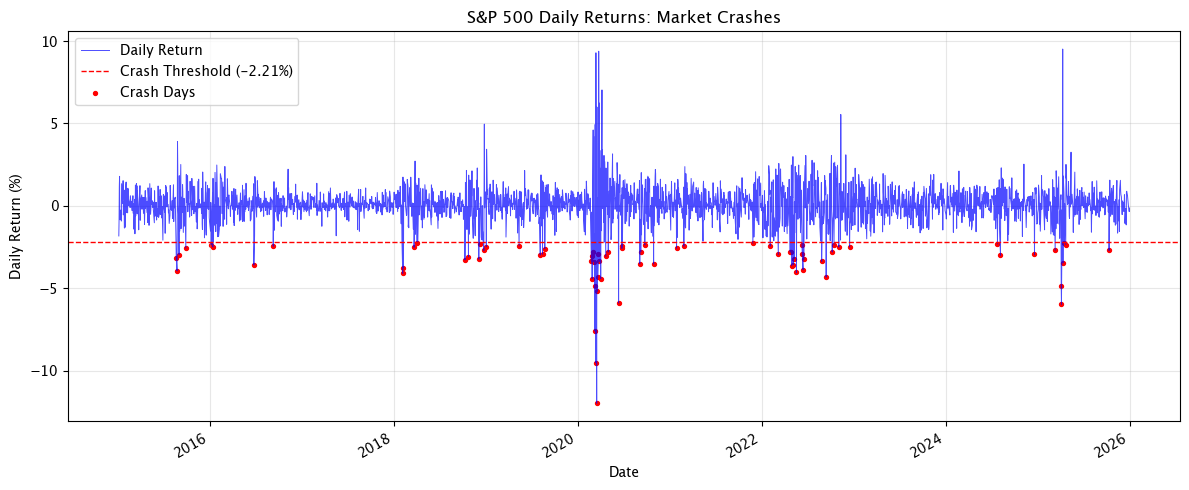

In [153]:
ax4 = (sp500["Daily Return"] * 100).plot(figsize=(12, 5),color="blue", linewidth=0.7, alpha=0.7, title="S&P 500 Daily Returns: Market Crashes", ylabel="Daily Return (%)", xlabel="Date", grid=True)
ax4.axhline(y=crash_threshold *100,color="red", linestyle="--", linewidth=1, label=f"Crash Threshold ({(crash_threshold*100).round(2)}%)")
ax4.scatter(crash_days.index, crash_days["Daily Return"] *100, color="red", s=8,label="Crash Days")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Since we are interested in *individual stock crashes*, we will focus mainly on each of them individually.

### Stock Crashes

In [154]:
stocks = yf.download(final_sample["Symbol"].tolist(), start=start_date, end=end_date)
stocks.head()

[*********************100%***********************]  50 of 50 completed


Price           Close                                              \
Ticker            ADI        AOS       APTV        BAC        BAX   
Date                                                                
2015-01-02  44.354492  23.357473  57.221508  14.203642  33.172565   
2015-01-05  43.547905  22.948799  54.722660  13.791022  32.349014   
2015-01-06  42.525692  22.761133  54.375813  13.378406  32.177078   
2015-01-07  42.972904  22.927942  54.809368  13.441887  32.330917   
2015-01-08  43.731583  23.524288  56.157337  13.719614  33.168034   

Price                                                        ...   Volume  \
Ticker             BKNG CARR        CHD       CINF      CMG  ...       SO   
Date                                                         ...            
2015-01-02  1123.673950  NaN  34.031300  37.878403  13.5680  ...  4645300   
2015-01-05  1079.909790  NaN  33.652634  37.335293  13.3538  ...  7028700   
2015-01-06  1062.573486  NaN  33.372944  37.049068  13.2876  ...  9358300   
2015-01-07  1052.350708  NaN  33.747311  37.555481  13.8852  ...  4917000   
2015-01-08  1065.417236  NaN  34.414261  38.355465  14.3998  ...  4532500   

Price                                                                          \
Ticker          SPG      SYK      TER TTD      VTR     WDAY      WDC      WSM   
Date                                                                            
2015-01-02  1229100  1523700  1030300 NaN  1740366  1630000  1278547  1044400   
2015-01-05  1267300  1825500  1877000 NaN  2447932  1591400  2199752   743200   
2015-01-06  2915600  1855000  2377700 NaN  3771815  1584000  2665713  1776000   
2015-01-07  2138400  1145300   902400 NaN  2613176  1106100  2054222  1719800   
2015-01-08  1640900  1368800  1626800 NaN  3219161  2090100  3351291  1342800   

Price               
Ticker         WST  
Date                
2015-01-02  268900  
2015-01-05  338400  
2015-01-06  430400  
2015-01-07  393100  
2015-01-08  247500  

[5 rows x 250 columns]